# Titanic Survival with DNN

Supervised Learning. Binary classification

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. A description of this dataset is on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=0)
sns.set()

Using TensorFlow backend.


## Load and prepare the data

In [2]:
data_path = 'data/titanic_data.csv'
df = pd.read_csv(data_path)
print("{} rows \n{} columns".format(*df.shape))
df.head(6)

891 rows 
12 columns


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.describe(include=['O'])  # non-numerical variables

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Albimona, Mr. Nassef Cassem",male,CA. 2343,G6,S
freq,1,577,7,4,644


Binary target "Survived": ~38% ones, ~62% ones. F1 score won't be used. <br>
Some features (e.g. PassengerID, Name, Ticket) are irelevant to survival probabilities. Also some values are missing for key values (e.g. Age)

### Improve features

In [5]:
# Enhance and add new features

# Cabin: Get first letter
df["Cabin"] = df["Cabin"].str[0]

# Get Title from Name
df['Title'] = df["Name"].str.extract('([A-Za-z]+)\.', expand=False)

# remove low frequency values
fields = ['Cabin', 'Title']
df.loc[:, fields] = helper.remove_lowfreq(df.loc[:, fields])  

# Alone passenger 
df['Alone'] = ((df["SibSp"] + df["Parch"]) == 0).astype(int)


Cabin {'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13}
Title {'Mr': 517, 'Miss': 182, 'Mrs': 125, 'Master': 40}


In [6]:
# Delete irrelevant features
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns')

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone
0,0,3,male,22.0,1,0,7.2500,NaN,S,Mr,0
1,1,1,female,38.0,1,0,71.2833,C,C,Mrs,0
2,1,3,female,26.0,0,0,7.9250,NaN,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,C,S,Mrs,0
4,0,3,male,35.0,0,0,8.0500,NaN,S,Mr,1


### Sort features

In [7]:
# Define target and features
target = ['Survived']
original_features = [f for f in list(df) if f not in target]

df = df[original_features + target]   # sort colums

#numerical = list(df.select_dtypes(include=[np.number]))
numerical = ["Age", "SibSp", "Parch", "Fare"]
categorical = [f for f in list(df) if f not in numerical]

print("Numerical fields: {}".format(numerical))
print("Categorical fields: {}".format(categorical))

Numerical fields: ['Age', 'SibSp', 'Parch', 'Fare']
Categorical fields: ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Alone', 'Survived']


### Fill missing values

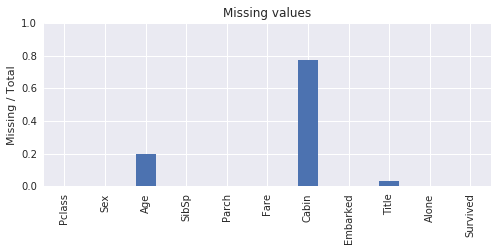

In [8]:
# show missing values
helper.show_missing(df)

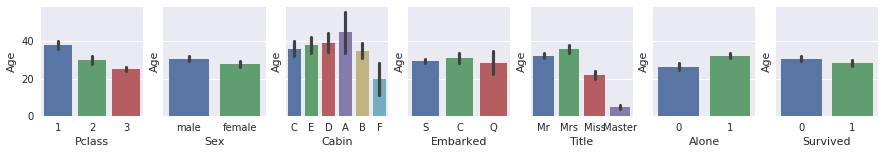

In [9]:
# Fill Age
helper.show_categorical(df, ["Age"], categorical, figsize=(15,2))

In [10]:
# the median of Age for different Pclass and Tittle will be used
ref = df[['Pclass', 'Title', 'Age']].groupby(['Pclass', 'Title'], as_index=False).median()
ref.rename(columns={'Age': 'Age_median'}, inplace=True)
ref

,Pclass,Title,Age_median
0,1,Master,4.0
1,1,Miss,30.0
2,1,Mr,40.0
3,1,Mrs,41.5
4,2,Master,1.0
5,2,Miss,24.0
6,2,Mr,31.0
7,2,Mrs,32.0
8,3,Master,4.0
9,3,Miss,18.0


In [11]:
# temporal add Age_median to the data to fill NaNs
df = df.merge(ref[['Pclass', 'Title', 'Age_median']], on=['Pclass', 'Title'], how='left')
df['Age'].fillna(df['Age_median'], inplace=True)
df.drop('Age_median', axis='columns', inplace=True)

In [12]:
# Fill rest of categorical variables with the mode

modes = df[categorical].mode()   # this solves fillna issue with mode()   
for idx, f in enumerate(df[categorical]):
    df[f] = df[f].fillna(modes.iloc[0,idx])

    # df.apply(lambda x: x.fillna(x.mean()),axis=0)
#df.mode()

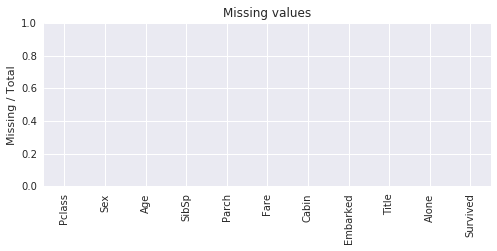

In [13]:
# replace numeric NaN values with the median (not needed here)
df.fillna(df.median(), inplace=True)  

helper.show_missing(df)

### Visualize the data

(0, 1)

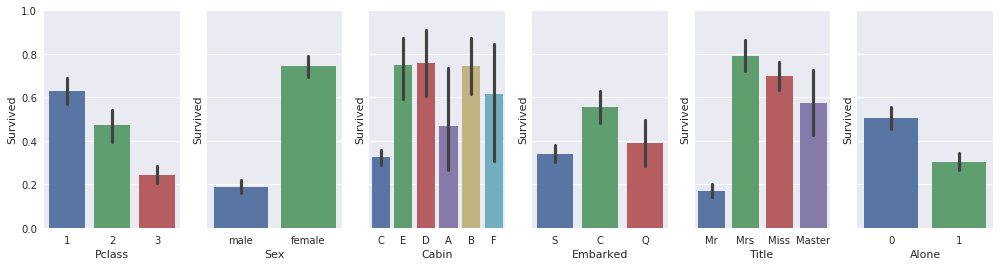

In [14]:
# Target vs Categorical features
helper.show_categorical(df, target, categorical)
plt.ylim([0, 1])

# df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

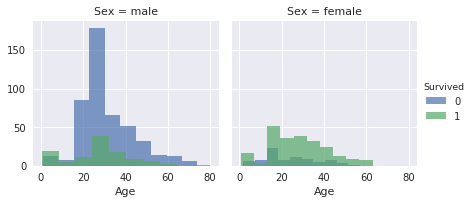

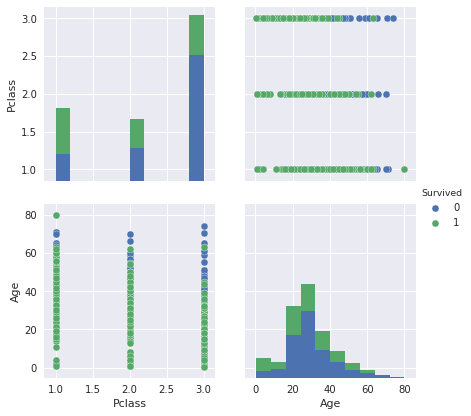

In [15]:
sns.FacetGrid(df, col="Sex",hue="Survived", size=3).map(plt.hist, "Age", alpha=.7).add_legend();
#male_df = df[df['Sex']=='male']
sns.pairplot(df, size=3, hue='Survived', vars=['Pclass', 'Age'])


The sex of the passenger is the key feature for survival, as most women survived, followed by children under 6 approximately.

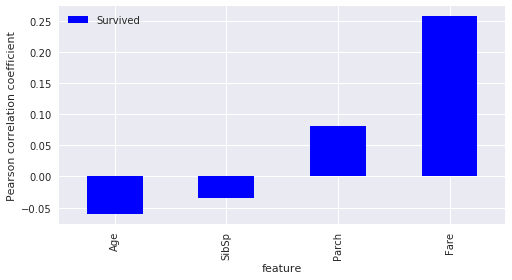

In [16]:
corr = df.corr().loc[numerical, target]

corr.plot.bar(figsize=(8, 4), colormap='winter')
plt.xlabel('feature')
plt.ylabel('Pearson correlation coefficient')
#sns.heatmap(corr, cmap="bwr")

### Select the features

In [17]:
drop = []
features = [f for f in original_features if f not in drop]

# From now use data instead of df
data = df[features + target]
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone,Survived
0,3,male,22.0,1,0,7.2500,C,S,Mr,0,0
1,1,female,38.0,1,0,71.2833,C,C,Mrs,0,1
2,3,female,26.0,0,0,7.9250,C,S,Miss,1,1
3,1,female,35.0,1,0,53.1000,C,S,Mrs,0,1
4,3,male,35.0,0,0,8.0500,C,S,Mr,1,0


### Normalize numerical variables

Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [18]:
scaled_features = {}
for f in numerical:
    if f in (features + target):
        mean, std = data[f].mean(), data[f].std()
        scaled_features[f] = [mean, std]
        data[f] = (data[f] - mean)/std

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone,Survived
0,3,male,-0.528175,0.432550,-0.473408,-0.502163,C,S,Mr,0,0
1,1,female,0.658128,0.432550,-0.473408,0.786404,C,C,Mrs,0,1
2,3,female,-0.231600,-0.474279,-0.473408,-0.488580,C,S,Miss,1,1
3,1,female,0.435696,0.432550,-0.473408,0.420494,C,S,Mrs,0,1
4,3,male,0.435696,-0.474279,-0.473408,-0.486064,C,S,Mr,1,0


### Create dummy features

In [19]:
# Only features,target one-hot encode is performed later
for f in categorical:
    if f in features:  
        dummies = pd.get_dummies(data[f], prefix=f, drop_first=False)
        data = pd.concat([data, dummies], axis=1)
        data.drop(f, axis=1, inplace=True)    
        

nn_features = [f for f in list(data) if f not in target]  # neural networks features

data = data[nn_features + target]  # reorder columns (target last)

### Split the data into training, and test sets

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.25, random_state=9)

# Separate the data into features and target (x=features, y=target)
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet (needs one-hot encoding)


### One-hot encode the output

In [21]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

(668, 24) (668, 2)
(223, 24) (223, 2)


## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________

Training ....
CPU times: user 1.2 s, sys: 16 ms, total: 1.22 s
Wall time: 1.25 s


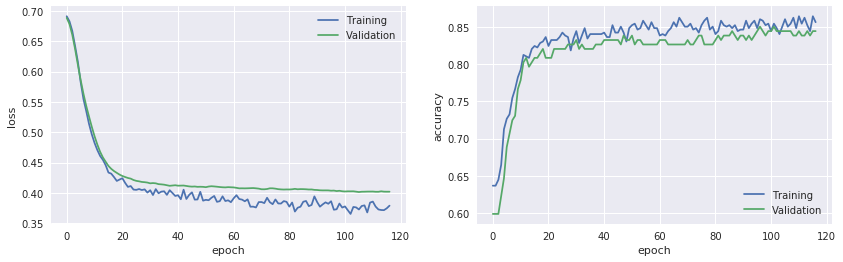


Training loss:  	0.3788
Validation loss: 	0.4019

Training accuracy: 	0.86
Validation accuracy:	0.84

Model saved at models/titanic.h5


In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

input_nodes = x_train.shape[1]
weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('\nTraining ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)]
%time history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, validation_split=0.25, callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "titanic.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Evaluate the model

In [23]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}".format(score[1]))

Model loaded: models/titanic.h5

Test Accuracy: 0.82


### Make predictions

In [24]:
def show_survival(passengers):
    """
    input: dictionary of passengers index: features values
    """
    
    # create a dataframe for the new data only
    new_df = pd.DataFrame(columns=list(df[features]))
    for key, value in passengers.items():
        new_df.loc[key] = value    
    
    new_data = new_df
    # create dummy features    
    for f in categorical:
        if f in features:  
            dummies = pd.get_dummies(new_data[f], prefix=f, drop_first=False)
            new_data = pd.concat([new_data, dummies], axis=1)
            new_data.drop(f, axis=1, inplace=True)   
    
       
    # add missing dummies
    missing = set(nn_features) - set(new_data)  # nn_features: ordered neural network features (with dummies)
    for m in missing:
        new_data[m] = 0
        
    # order columns
    new_data = new_data[nn_features]
    
    for f in numerical:
        if f in features:
            new_data.loc[:, f] = (new_data[f] - scaled_features[f][0]) / scaled_features[f][1]    
    
    print('Survival Probabilities: \n')
    
    # make prediction
    for index, row in new_data.iterrows():    
        single_pred = model.predict(np.array([row]))    
        print('{}:\t {:.0f}%'.format(index,single_pred[0,1] * 100))

In [25]:
# input data format
print(" MEDIAN: \n{}".format(dict(df[features].median())))
print("\n MODE:")
df[features].mode()

 MEDIAN: 
{'Pclass': 3.0, 'Age': 26.0, 'SibSp': 0.0, 'Parch': 0.0, 'Fare': 14.4542, 'Alone': 1.0}

 MODE:


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone
0,3,male,26.0,0,0,8.05,C,S,Mr,1


In [26]:
new_passengers = {'Average man':    [2, 'male',   26, 1, 0, 14, 'C', 'S', 'Mr', 0],
                  'Average woman':  [2, 'female', 26, 1, 0, 14, 'C', 'S', 'Mrs', 0],
                  'Alone woman 3c': [3, 'female', 26, 0, 0, 8,  'C', 'S', 'Miss', 1],
                  'Boy 1c ':        [1, 'male',   11, 0, 2, 31, 'C', 'S', 'Mr', 0],
                  'Boy 2c ':        [1, 'male',   11, 0, 2, 14, 'C', 'S', 'Mr', 0],
                  'Boy 3c ':        [3, 'male',   11, 0, 2, 8,  'C', 'S', 'Mr', 0],
                  'Girl 3c':        [1, 'female', 11, 0, 2, 8, 'C', 'S', 'Miss', 0],
                 }

show_survival(new_passengers)

Survival Probabilities: 

Average man:	 8%
Average woman:	 92%
Alone woman 3c:	 53%
Boy 1c :	 33%
Boy 2c :	 32%
Boy 3c :	 10%
Girl 3c:	 92%


The results predicted from the model confirm the impact of the sex for the survival probabilities, as well as the class for the survival of male teenagers.

## Compare with classical machine learning

In [27]:
CV = True  # If True an additional training with cross validation will be performed

from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.base import clone

classifiers = (GaussianNB(), SVC(kernel="rbf",), DecisionTreeClassifier(),
               KNeighborsClassifier(n_neighbors=10), AdaBoostClassifier(), RandomForestClassifier(100))

names = ["Naive Bayes", "SVM", "Decision Trees", "KNeighbors", "AdaBoost", "Random Forest"]

for idx, clf in enumerate(classifiers):
    
    print("\n", names[idx],"\n", "-"*20)

    t0 = time()
    # Fitting the model without cross validation
    clf.fit(x_train, y_train[:,0])
    t1 = time()
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test[:,0])

    if CV:        
        clone(clf, safe=True)
        k_fold = KFold(10)

        t3 = time()
        # Fitting the model with cross validation (CV)
        for train, test in k_fold.split(x_train, y_train):
            clf.fit(x_train, y_train[:,0])
        t4 = time()
    
    y_pred_cv = clf.predict(x_test)
    accuracy_cv = accuracy_score(y_pred_cv, y_test[:,0])

    print("Test Accuracy:  \t {:.2f}".format(accuracy))    
    if CV:
        print("Test Accuracy CV:\t {:.2f}".format(accuracy_cv))  
    
    print("Training Time:  \t {:.1f} ms".format((t1 - t0)*1000))
    if CV:
        print("Training Time CV: \t {:.1f} ms".format((t4 - t3)*1000))


 Naive Bayes 
 --------------------
Test Accuracy:  	 0.79
Test Accuracy CV:	 0.79
Training Time:  	 0.9 ms
Training Time CV: 	 5.7 ms

 SVM 
 --------------------
Test Accuracy:  	 0.80
Test Accuracy CV:	 0.80
Training Time:  	 17.0 ms
Training Time CV: 	 152.5 ms

 Decision Trees 
 --------------------
Test Accuracy:  	 0.76
Test Accuracy CV:	 0.77
Training Time:  	 1.4 ms
Training Time CV: 	 14.2 ms

 KNeighbors 
 --------------------
Test Accuracy:  	 0.80
Test Accuracy CV:	 0.80
Training Time:  	 0.7 ms
Training Time CV: 	 6.1 ms

 AdaBoost 
 --------------------
Test Accuracy:  	 0.79
Test Accuracy CV:	 0.79
Training Time:  	 69.7 ms
Training Time CV: 	 697.6 ms

 Random Forest 
 --------------------
Test Accuracy:  	 0.81
Test Accuracy CV:	 0.80
Training Time:  	 131.5 ms
Training Time CV: 	 1309.3 ms
